# Fitting Gaussian Processes using GPFlow


In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pylab as plt

%matplotlib inline
np.random.seed(42)

We will use some simulated data as a test case for comparing the performance of each package. I don't actually recall where I found this data, so I have no details regarding how it was generated . However, it clearly shows some type of non-linear process, corrupted by a certain amount of observation or measurement error so it should be a reasonable task for a Gaussian process approach.

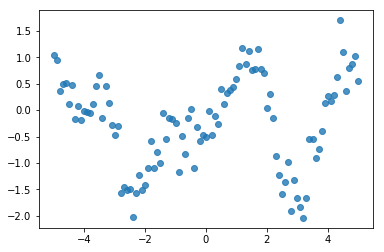

In [2]:
%run utils/get_data.py
sns.regplot(x, y, fit_reg=False)

## Single Gaussian Process

One of the early projects to provide a standalone package for fitting Gaussian processes in Python was [GPy](http://sheffieldml.github.io/GPy/) by the Sheffield machine learning group. Much like `scikit-learn`'s `gaussian_process` module, GPy provides a set of classes for specifying and fitting Gaussian processes, with a large library of kernels that can be combined as needed. GPflow is a re-implementation of the GPy library, using Google's popular [TensorFlow](https://www.tensorflow.org) library as its computational backend. The main advantage of this change for most users is that it allows the use of more modern methods for fitting larger GP models, namely variational inference and Markov chain Monte Carlo.

Let's demonstrate GPflow usage by fitting our simulated dataset. The API is slightly more general than `scikit-learns`, as it expects tabular inputs for both the predictors (features) and outcomes. Hence, we must reshape `y` to a tabular format:

In [3]:
Y = y.reshape(-1,1)
X = x.reshape(-1,1)

To mirror the scikit-learn model, we will again specify a Matèrn covariance function. GPflow has two user-facing subclasses, one which fixes the roughness parameter to 3/2 (Matern32) and another to 5/2 (Matern52). Amplitude is an included parameter (variance), so we do not need to include a separate constant kernel.

In [4]:
import gpflow

k = gpflow.kernels.Matern32(1, variance=1, lengthscales=1.2)

There are six different GP classes, chosen according to the covariance structure (full vs. sparse approximation) and the likelihood of the model (Gaussian vs. non-Gaussian). The main innovation of GPflow is that non-conjugate models (i.e. those with a non-normal likelihood) can be fit either using Markov chain Monte Carlo or an approximation via variational inference.

Since our model involves a straightforward conjugate Gaussian likelihood, we can use the GPR (Gaussian process regression) class.

In [5]:
m = gpflow.gpr.GPR(X, Y, kern=k)

We can access the parameter values simply by printing the regression model object.

In [7]:
print(m)

name.kern.lengthscales transform:+ve prior:None
[ 1.2]
name.kern.variance transform:+ve prior:None
[ 1.]
name.likelihood.variance transform:+ve prior:None
[ 1.]



Notice that, in addition to the hyperparameters of the Matèrn kernel, there is an additional variance parameter that is associated with the normal likelihood. We can set it to non-default values by direct assignment.

In [8]:
m.likelihood.variance = 0.01
print(m)

name.kern.lengthscales transform:+ve prior:None
[ 1.2]
name.kern.variance transform:+ve prior:None
[ 1.]
name.likelihood.variance transform:+ve prior:None
[ 0.01]



This model is fit using the optimize method, which runs a gradient ascent algorithm on the model likelhiood (it uses the minimize function from SciPy as a default optimizer).

In [9]:
m.optimize()

      fun: 54.247759719230793
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.90014566e-06,  -2.77533971e-06,   3.09872005e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 15
   status: 0
  success: True
        x: array([ 0.6063578,  0.3208171, -2.3496958])

In [10]:
m

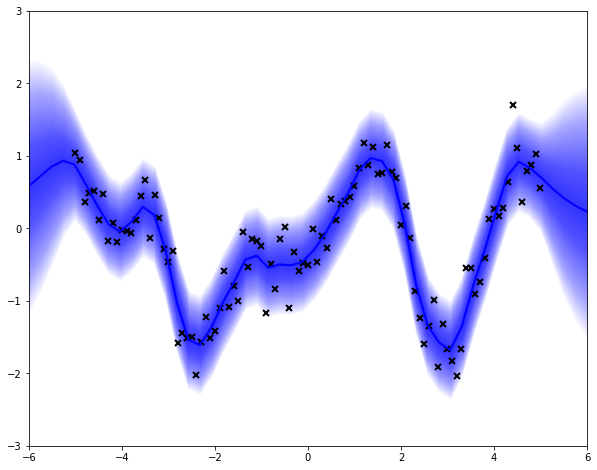

In [100]:
plt.figure(figsize=(10,8))
xx = np.linspace(-6, 6).reshape(-1,1)

def plot(m):
    mean, var = m.predict_y(xx)
    
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    
    numsteps = 100
    for i in reversed(range(1,numsteps+2)):
        top = mean[:,0] + np.sqrt(var[:,0])/numsteps*i*2
        bottom = mean[:,0] - np.sqrt(var[:,0])/numsteps*i*2
        topp = mean[:,0] + np.sqrt(var[:,0])/numsteps*(i+1)*2
        bottomp = mean[:,0] - np.sqrt(var[:,0])/numsteps*(i+1)*2
        
        alpha_ = np.exp(-(i*i)/(2*numsteps/2*numsteps/2))                       
        plt.fill_between(xx[:,0], bottom, top, color='blue', alpha=1/numsteps)
        #plt.fill_between(xx[:,0], bottomp, topp, color='white', alpha=1)
    
    #plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.xlim(-6, 6)
    plt.ylim(-3, 3)
    
plot(m)

0.136421216429
0.137513662937
0.138612639819
0.139718163958
0.140830252054
0.141948920625
0.143074186004
0.144206064333
0.145344571566
0.146489723462
0.147641535585
0.1488000233
0.14996520177
0.151137085957
0.152315690614
0.153501030289
0.154693119314
0.155891971812
0.157097601686
0.158310022622
0.159529248084
0.160755291312
0.16198816532
0.163227882891
0.164474456577
0.165727898697
0.166988221332
0.168255436322
0.169529555268
0.170810589523
0.172098550195
0.173393448142
0.174695293967
0.176004098022
0.177319870398
0.178642620927
0.179972359179
0.181309094458
0.182652835799
0.184003591968
0.185361371457
0.186726182484
0.188098032987
0.189476930624
0.19086288277
0.192255896513
0.193655978653
0.1950631357
0.19647737387
0.197898699084
0.199327116961
0.200762632823
0.202205251687
0.203654978262
0.205111816952
0.206575771847
0.208046846725
0.209525045047
0.211010369957
0.212502824275
0.214002410501
0.215509130807
0.217022987038
0.218543980707
0.220072112995
0.221607384746
0.223149796467
0.2

You might have noticed that there is nothing particularly Bayesian about what we have done here. No priors have been specified, and we have just performed maximum likelihood to obtain a solution.

In [11]:
m.kern.variance.prior = gpflow.priors.Gamma(1,0.1)
m.kern.lengthscales.prior = gpflow.priors.Gamma(1,0.1)

In addition to specifying priors on the hyperparameters, we can also fix values if we have information to justify doing so. For example, we may know the measurement error of our data-collecting instrument, so we can assign that error value as a constant.

In [12]:
m.likelihood.variance = 0.1
m.likelihood.variance.fixed = True

In [13]:
print(m)

name.kern.lengthscales transform:+ve prior:Ga([ 1.],[ 0.1])
[ 1.04159852]
name.kern.variance transform:+ve prior:Ga([ 1.],[ 0.1])
[ 0.86636739]
name.likelihood.variance transform:+ve prior:None [FIXED]
[ 0.1]



In [14]:
m.optimize()

      fun: 63.930638821012913
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  8.13287712e-07,  -3.35442311e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 6
   status: 0
  success: True
        x: array([-0.16326004, -0.75649791])

Though we may feel satisfied that we have a proper Bayesian model, the end result is very much the same. All we have done is added the log-probabilities of the priors to the model, and performed optimization again. This time, the result is a maximum *a posteriori* (MAP) estimate.

In [15]:
print(m)

name.kern.lengthscales transform:+ve prior:Ga([ 1.],[ 0.1])
[ 0.6148462]
name.kern.variance transform:+ve prior:Ga([ 1.],[ 0.1])
[ 0.38479193]
name.likelihood.variance transform:+ve prior:None [FIXED]
[ 0.1]



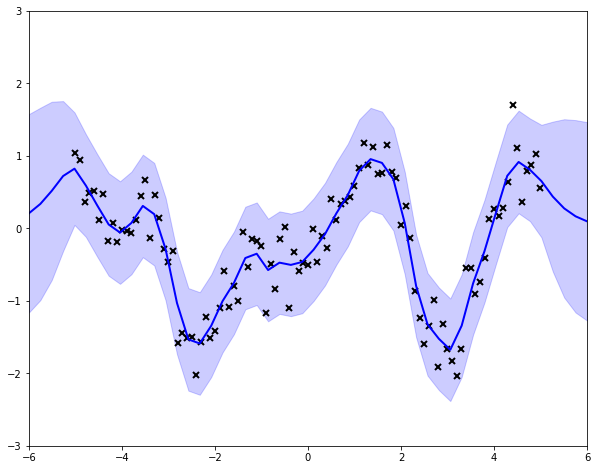

In [16]:
plt.figure(figsize=(10,8))
def plot(m):
    mean, var = m.predict_y(xx)
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.xlim(-6, 6)
    plt.ylim(-3, 3)
plot(m)

To perform a "Fully Bayesian" analysis, we can use the more general `GPMC` class, which jointly samples over the parameters and the functions. For this, we need to specify a likelihood as well as priors for the kernel parameters. Let's change the model slightly and use a Student's T likelihood, which will be more robust to the influence of extreme values.

In [17]:
l = gpflow.likelihoods.StudentT()
m = gpflow.gpmc.GPMC(X, Y, kern=k, likelihood=l)

In [18]:
m.kern.variance.prior = gpflow.priors.Gamma(1,1)
m.kern.lengthscales.prior = gpflow.priors.Gamma(1,1)

Rather than optimize, we fit the GPMC model using the sample method. This will employ Hamiltonian Monte Carlo (HMC), an efficient form of Markov chain Monte Carlo that takes advantage of gradient information to improve posterior sampling. The TensorFlow library provides automatic differentiation functions that allow the gradient to be calculated for arbitrary models. The HMC algorithm requires the specification of hyperparameter values that determine the behavior of the sampling procedure; these parameters can be tuned.

In [19]:
trace = m.sample(1000, verbose=True, epsilon=0.03, Lmax=15)

Iteration:  100 	 Acc Rate:  96.0 %
Iteration:  200 	 Acc Rate:  93.0 %
Iteration:  300 	 Acc Rate:  94.0 %
Iteration:  400 	 Acc Rate:  95.0 %
Iteration:  500 	 Acc Rate:  93.0 %
Iteration:  600 	 Acc Rate:  96.0 %
Iteration:  700 	 Acc Rate:  95.0 %
Iteration:  800 	 Acc Rate:  96.0 %
Iteration:  900 	 Acc Rate:  95.0 %
Iteration:  1000 	 Acc Rate:  95.0 %


We end up with a trace containing sampled values from the kernel parameters, which can be plotted to get an idea about the posterior uncertainty in their values, after being informed by the data.

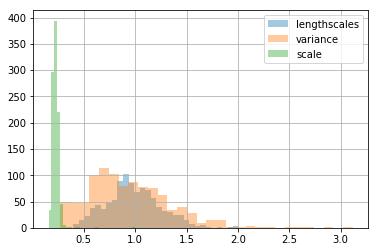

In [20]:
parameter_samples = m.get_samples_df(trace)

for col in parameter_samples.columns.sort_values()[1:]:
    parameter_samples[col].hist(label=col.split('.')[-1], alpha=0.4, bins=30)
    
plt.legend()

We can then go back and generate predictions from the posterior GP, and plot several of them to get an idea of the predicted underlying function.

In [21]:
realizations = []
for sample in trace[-100:]:
    m.set_state(sample)
    realizations.append(m.predict_f_samples(xx, 1).squeeze())
realizations = np.vstack(realizations)

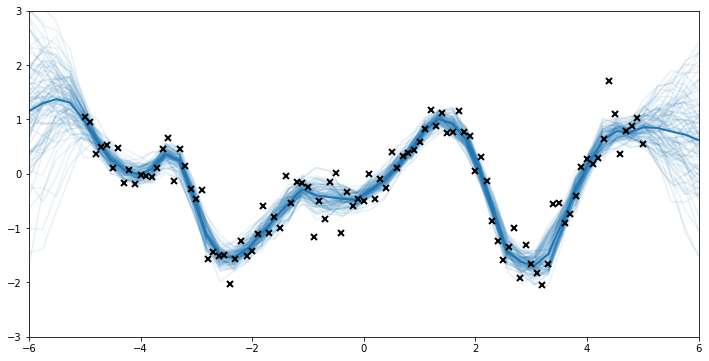

In [22]:
plt.figure(figsize=(12, 6))
line, = plt.plot(xx.squeeze(), np.mean(realizations, 0), lw=2)
for draw in realizations:
    plt.plot(xx.squeeze(), draw, color=line.get_color(), alpha = 0.1)
plt.plot(X, Y, 'kx', mew=2)
plt.xlim(-6, 6)
plt.ylim(-3, 3);

## Multi-task GP

Lets create a dataset with two outputs, correlated, heavy-tail noise. One has more noise than the other.

In [23]:
X1 = np.random.rand(100, 1)
X2 = np.random.rand(50, 1) * 0.5
Y1 = np.sin(6*X1) + np.random.standard_t(3, X1.shape)*0.03
Y2 = np.sin(6*X2+ 0.7) + np.random.standard_t(3, X2.shape)*0.1

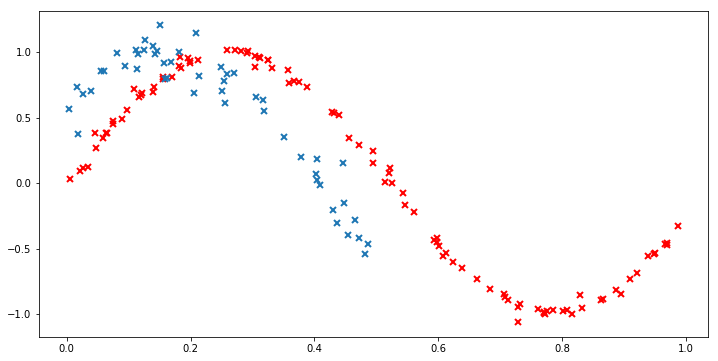

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(X1, Y1, 'rx', mew=2)
plt.plot(X2, Y2, 'x', mew=2)

Lets use the same strategy as Bonilla et al.. 

In [61]:
# build a variational model
lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.StudentT(), gpflow.likelihoods.StudentT()])
k1 = gpflow.kernels.Matern32(1)
coreg = gpflow.kernels.Coregion(1, output_dim=2, rank=1, active_dims=[1])
kern = k1 * coreg
X_augmented = np.vstack((np.hstack((X1, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X2)))))
Y_augmented = np.vstack((np.hstack((Y1, np.zeros_like(X1))), np.hstack((Y2, np.ones_like(X2)))))

In [62]:
#m = gpflow.vgp.VGP(X_augmented, Y_augmented, kern=kern, likelihood=lik, num_latent=1)
#m = gpflow.gpr.GPR(X_augmented, Y_augmented,
#                     kern=kern)
m = gpflow.svgp.SVGP(X_augmented, Y_augmented,
                     kern=kern, likelihood=lik, num_latent=1,
                     Z=X_augmented[::3].copy())

(-2, 2)

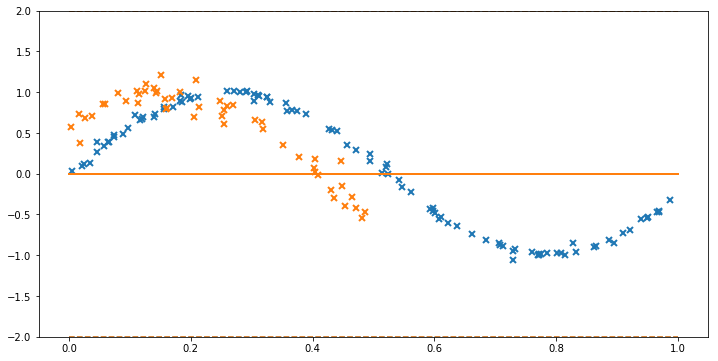

In [63]:
plt.figure(figsize=(12, 6))
xtest = np.linspace(0, 1, 100)[:,None]
line, = plt.plot(X1, Y1, 'x', mew=2)
mu, var = m.predict_f(np.hstack((xtest, np.zeros_like(xtest))))
plt.plot(xtest, mu, color=line.get_color(), lw=2)
plt.plot(xtest, mu + 2*np.sqrt(var), '--', color=line.get_color())
plt.plot(xtest, mu - 2*np.sqrt(var), '--', color=line.get_color())

line, = plt.plot(X2, Y2, 'x', mew=2)
mu, var = m.predict_f(np.hstack((xtest, np.ones_like(xtest))))
plt.plot(xtest, mu, color=line.get_color(), lw=2)
plt.plot(xtest, mu + 2*np.sqrt(var), '--', color=line.get_color())
plt.plot(xtest, mu - 2*np.sqrt(var), '--', color=line.get_color())

plt.ylim(-2, 2)

In [64]:
 m.optimize(max_iters=500)

C:\Users\mpimentel\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\mpimentel\Anaconda3\lib\site-packages\gpflow\model.py:317: VisibleDeprecationWarning: Use `maxiter` instead of deprecated `max_iters`.
  warnings.warn("Use `maxiter` instead of deprecated `max_iters`.", np.VisibleDeprecationWarning)


      fun: -172.77933010961848
 hess_inv: <1433x1433 LbfgsInvHessProduct with dtype=float64>
      jac: array([  8.20412159e+01,  -0.00000000e+00,  -2.23922239e+01, ...,
        -8.19102742e-05,  -8.86750967e-03,   5.87354993e-02])
  message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 582
      nit: 501
   status: 1
  success: False
        x: array([ 0.41768766,  0.        ,  0.6242215 , ...,  0.00457771,
        0.00448898,  0.82303817])

In [65]:
m.kern

(-2, 2)

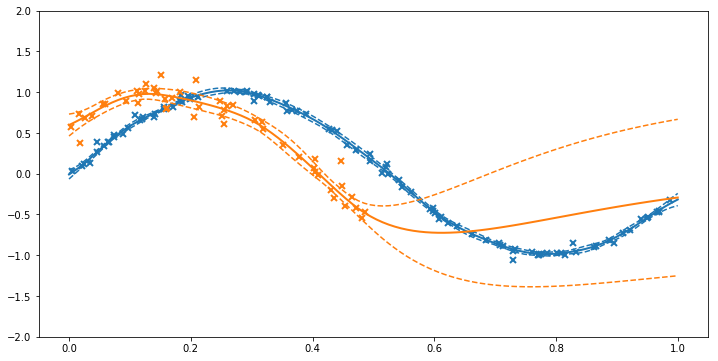

In [66]:
plt.figure(figsize=(12, 6))
xtest = np.linspace(0, 1, 100)[:,None]
line, = plt.plot(X1, Y1, 'x', mew=2)
mu, var = m.predict_f(np.hstack((xtest, np.zeros_like(xtest))))
plt.plot(xtest, mu, color=line.get_color(), lw=2)
plt.plot(xtest, mu + 2*np.sqrt(var), '--', color=line.get_color())
plt.plot(xtest, mu - 2*np.sqrt(var), '--', color=line.get_color())

line, = plt.plot(X2, Y2, 'x', mew=2)
mu, var = m.predict_f(np.hstack((xtest, np.ones_like(xtest))))
plt.plot(xtest, mu, color=line.get_color(), lw=2)
plt.plot(xtest, mu + 2*np.sqrt(var), '--', color=line.get_color())
plt.plot(xtest, mu - 2*np.sqrt(var), '--', color=line.get_color())

plt.ylim(-2, 2)

In [67]:
m.kern.coregion.W = np.random.randn(2, 1)

In [68]:
m.optimize()

      fun: -185.07328014960376
 hess_inv: <1433x1433 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.15915894e+01,  -0.00000000e+00,   3.87070179e+00, ...,
         4.82608622e-02,  -3.83031755e-03,  -5.27057329e-02])
  message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 1120
      nit: 1001
   status: 1
  success: False
        x: array([ 0.4282607 ,  0.        ,  0.62248246, ...,  0.07215031,
        0.04451534,  0.81064668])

(-2, 2)

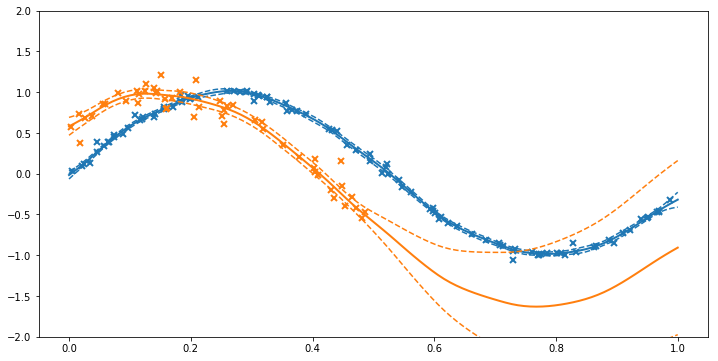

In [69]:
plt.figure(figsize=(12, 6))
xtest = np.linspace(0, 1, 100)[:,None]
line, = plt.plot(X1, Y1, 'x', mew=2)
mu, var = m.predict_f(np.hstack((xtest, np.zeros_like(xtest))))
plt.plot(xtest, mu, color=line.get_color(), lw=2)
plt.plot(xtest, mu + 2*np.sqrt(var), '--', color=line.get_color())
plt.plot(xtest, mu - 2*np.sqrt(var), '--', color=line.get_color())

line, = plt.plot(X2, Y2, 'x', mew=2)
mu, var = m.predict_f(np.hstack((xtest, np.ones_like(xtest))))
plt.plot(xtest, mu, color=line.get_color(), lw=2)
plt.plot(xtest, mu + 2*np.sqrt(var), '--', color=line.get_color())
plt.plot(xtest, mu - 2*np.sqrt(var), '--', color=line.get_color())

plt.ylim(-2, 2)

In [70]:
m.kern

In [78]:
a = 0.67770340
b = -0.004112505

In [83]:
(a*b)

-0.002787058621017